In [1]:
import json

In [2]:
from pathlib import Path
import os
import sys
import collections

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# KN-Interactor Analysis

**CPU vs GPU Comparisons**

*Tom Evans, 10/20/2020*

Run cases:
* constant numbers of tracks that runs multiple tracks per thread
* setting $N_t = G_s\times B_s$ so that there is only 1 track per thread

To execute cases do
```
python driver.py
```


In [4]:
home=Path('/home/9te/celeritas/benchmarks/klein-nishina/celeritas-results-cpu')

## Load Data

In [5]:
gpu_c = collections.defaultdict(list)
gpu = collections.defaultdict(list)

for f in home.glob("track*.json"):
    with open(f, 'r') as out:
        d = json.load(out)

    gs = d['grid_params']['grid_size']
    times = np.asarray(d['result']['time'])
    time = d['result']['total_time']
    kt = np.sum(times) / time
    tracks = d['run']['num_tracks']

    if 'const' in f.stem:
        gpu_c['grid_size'].append(gs)
        gpu_c['total_time'].append(time)
        gpu_c['trans_time'].append(kt*time)
        gpu_c['kernel_frac'].append(kt)
        gpu_c['num_tracks'].append(tracks)
    else:
        gpu['grid_size'].append(gs)
        gpu['total_time'].append(time)
        gpu['trans_time'].append(kt*time)
        gpu['kernel_frac'].append(kt)
        gpu['num_tracks'].append(tracks)

In [6]:
cpu = collections.defaultdict(list)

for f in home.glob("host*.json"):
    with open(f, 'r') as out:
        d = json.load(out)

    times = np.asarray(d['result']['time'])
    time = d['result']['total_time']
    rt = np.sum(times) / time
    tracks = d['run']['num_tracks']

    cpu['total_time'].append(time)
    cpu['trans_time'].append(rt*time)
    cpu['trans_frac'].append(rt)
    cpu['num_tracks'].append(tracks)    

## Comparison GPU v CPU times

In [7]:
gi = np.argsort(gpu['num_tracks'])
ci = np.argsort(cpu['num_tracks'])

gt = np.asarray(gpu['total_time'])[gi]
ct = np.asarray(cpu['total_time'])[ci]

gtt = np.asarray(gpu['trans_time'])[gi]
ctt = np.asarray(cpu['trans_time'])[ci]

ntracks = np.asarray(gpu['num_tracks'])[gi]

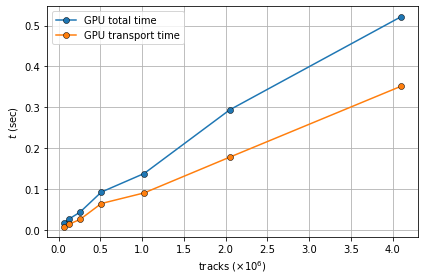

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(ntracks, gt, marker='o', markeredgecolor='black', markeredgewidth='0.5', label = 'GPU total time')
ax.plot(ntracks, gtt, marker='o', markeredgecolor='black', markeredgewidth='0.5', label = 'GPU transport time')
ax.grid()

ax.set_ylabel("$t$ (sec)")
ax.set_xlabel('tracks ($\\times 10^6$)')

ticks = ax.get_xticks() * 1e-6
ax.set_xticklabels(ticks)

ax.legend()

fig.tight_layout()
fig.savefig('gpu-runtime.pdf')

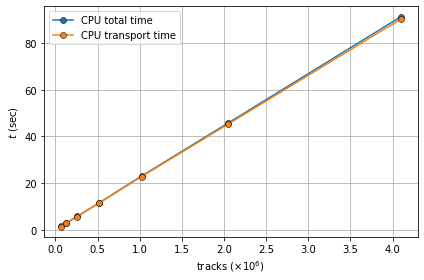

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(ntracks, ct, marker='o', markeredgecolor='black', markeredgewidth='0.5', label = 'CPU total time')
ax.plot(ntracks, ctt, marker='o', markeredgecolor='black', markeredgewidth='0.5', label = 'CPU transport time')
ax.grid()

ax.set_ylabel("$t$ (sec)")
ax.set_xlabel('tracks ($\\times 10^6$)')

ticks = ax.get_xticks() * 1e-6
ax.set_xticklabels(ticks)

ax.legend()

fig.tight_layout()
fig.savefig('cpu-runtime.pdf')

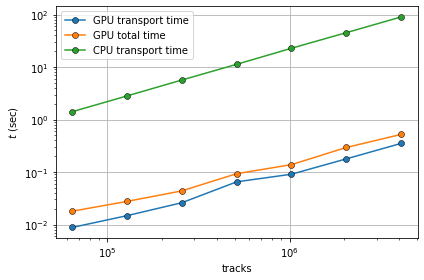

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(ntracks, gtt, marker='o', markeredgecolor='black', markeredgewidth='0.5', label = 'GPU transport time')
ax.plot(ntracks, gt, marker='o', markeredgecolor='black', markeredgewidth='0.5', label = 'GPU total time')
ax.plot(ntracks, ctt, marker='o', markeredgecolor='black', markeredgewidth='0.5', label = 'CPU transport time')
ax.grid()

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel("$t$ (sec)")
ax.set_xlabel('tracks')

#ticks = ax.get_xticks() * 1e-6
#ax.set_xticklabels(ticks)

ax.legend()

fig.tight_layout()
fig.savefig('cpu_v_gpu.pdf')

## Comparison of CPU and GPU Output

Compare energy depositions in $N=4096000$ track case.

In [11]:
with open('track-16000.json', 'r') as f:
    gdir = json.load(f)

with open('host-track-16000.json', 'r') as f:
    cdir = json.load(f)

In [12]:
edep_g = np.asarray(gdir['result']['edep'])
edep_c = np.asarray(cdir['result']['edep'])

In [26]:
diff = (edep_c - edep_g)

In [14]:
grid = gdir['run']['tally_grid']
delta = grid['delta']
front = grid['front']
size = grid['size']

In [15]:
bounds = np.arange(front,front+size*delta,delta)

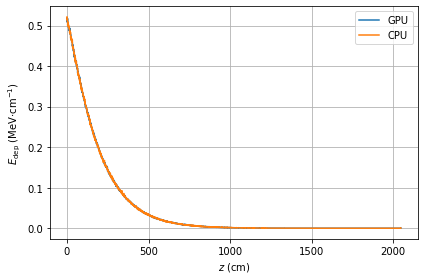

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(bounds, edep_g/delta, ds='steps-post', label='GPU')
ax.plot(bounds, edep_c/delta, ds='steps-post', label='CPU')
ax.grid()

ax.set_xlabel('$z$ (cm)')
ax.set_ylabel('$E_{\mathrm{dep}}$ (MeV$\cdot$cm$^{-1})$')

ax.legend()

fig.tight_layout()

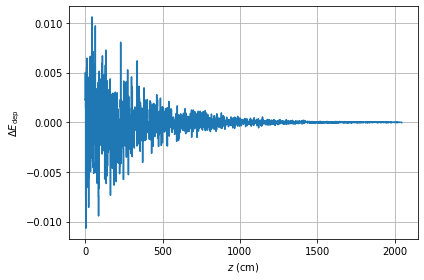

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(bounds, diff, ds='steps-post')
ax.grid()

ax.set_xlabel('$z$ (cm)')
ax.set_ylabel('$\Delta E_\mathrm{dep}$')

fig.tight_layout()

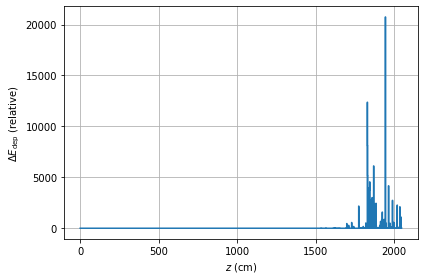

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(bounds, np.abs(diff)/edep_g, ds='steps-post')
ax.grid()

ax.set_xlabel('$z$ (cm)')
ax.set_ylabel('$\Delta E_\mathrm{dep}$ (relative)')

fig.tight_layout()

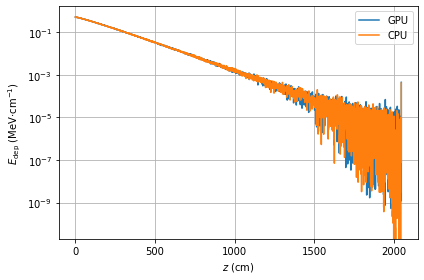

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(bounds, edep_g/delta, ds='steps-post', label='GPU')
ax.plot(bounds, edep_c/delta, ds='steps-post', label='CPU')
ax.grid()

ax.set_yscale('log')

ax.set_xlabel('$z$ (cm)')
ax.set_ylabel('$E_{\mathrm{dep}}$ (MeV$\cdot$cm$^{-1})$')

ax.legend()

fig.tight_layout()